In [55]:
# Load standard modules
import os
import numpy as np
import json
import math
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, timedelta
import xarray as xr
import zarr
import cmocean as cm

# Pytorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# cuda setup, set seed for reproducability 
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
set_seed(41)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print(f"Using device: {device}")


# YOU NEED THIS TO LOAD PyTorch Lightning I DON"T KNOW WHY

from jupyter_client.manager import KernelManager

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Set torch dtype to float64
torch.set_default_dtype(torch.float64)

# Set model path
import sys
sys.path.append('./src/')
import simvip_model
import data_loaders
import eval_physics


Using device: cpu


In [56]:
np.gradient(np.gradient(np.array([[1, 2, 6], [3, 4, 5], [3, 4, 5]]), axis=0),axis=0)

array([[-1. , -1. ,  0.5],
       [-1. , -1. ,  0.5],
       [-1. , -1. ,  0.5]])

In [57]:
import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i))

In [58]:
os.cpu_count()

48

In [59]:
print(torch.version.cuda)

12.4


In [60]:
torch.get_num_threads()

8

In [61]:
from importlib import reload
simvip_model = reload(simvip_model)
data_loaders = reload(data_loaders)
eval_physics = reload(eval_physics)

In [8]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
#SimVip_model = simvip_model.SimVP_Model_no_skip_sst(in_shape=(30,2,128,128)).to(device)
device

'cpu'

# Define the dataloaders

In [102]:
######################################################################################################
######################################################################################################
# Modules for loading data, set data pathimport urllib
DATASET_PATH = '/home/tm3076/scratch/pytorch_learning_tiles'
CHECKPOINT_PATH = '/home/tm3076/scratch/tm3076/pytorch_training'
DRIVE_PATH = "."

n_cpus = 0# torch.get_num_threads()#os.cpu_count()
mid_timestep = 100
N_t = 20
#pre-computed global normalisation stats
mean_ssh = 0.074
std_ssh = 0.0986
mean_sst = 293.307
std_sst = 8.726 

# Lambda transforms to apply to input fields
std_ssh_norm = lambda x: x/std_ssh
std_sst_norm = lambda x: x/std_sst
std_sst_norm = lambda x: (x-mean_sst)/std_sst
no_transform = lambda x: x

infields = ["zarr_llc4320_SSH_tiles_4km_filtered","zarr_llc4320_SST_tiles_4km","zarr_llc4320_SSU_tiles_4km","zarr_llc4320_SSV_tiles_4km"]
outfields = ["zarr_llc4320_SSH_tiles_4km_filtered","zarr_llc4320_SSH_tiles_4km",]
in_mask_list = ["swot",None,None,None]
out_mask_list = [None,None]
in_transform_list = [std_ssh_norm,std_sst_norm,no_transform,no_transform]
out_transform_list = [std_ssh_norm,std_ssh_norm]

#patch_coords = np.load(f'{DATASET_PATH}/np_SST_masks/x_y_coordinates.npy')
patch_coords = zarr.load(f'{DATASET_PATH}/x_y_coordinates_noland.zarr')
batch_size = 5

multiprocessing = False


# Data loader 
full_dataset = torch.utils.data.ConcatDataset([data_loaders.llc4320_dataset(DATASET_PATH, i_mid_timestep, N_t, patch_coords, 
                                                                            infields, outfields, in_mask_list, out_mask_list, 
                                                                            in_transform_list, out_transform_list, 
                                                                            multiprocessing = multiprocessing
                                                                           ) for i_mid_timestep in range(30,360,5)])


In [103]:
print(f"size full_dataset: {len(full_dataset)}")

# Split into train, validation, and test data
train_length = int(0.7*len(full_dataset))
validation_length = int(0.2*len(full_dataset))
test_length = len(full_dataset) - train_length - validation_length
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(full_dataset, (train_length, validation_length, test_length))

# Verify size of datasets
print(f"size train_dataset: {len(train_dataset)}")
print(f"size validation_dataset: {len(validation_dataset)}")
print(f"size test_dataset: {len(test_dataset)}")

def worker_init_fn(worker_id):
    worker_info = torch.utils.data.get_worker_info()

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpus, worker_init_fn = worker_init_fn, persistent_workers=multiprocessing)
val_data_loader   = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpus, worker_init_fn = worker_init_fn, persistent_workers=multiprocessing)
test_data_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpus, worker_init_fn = worker_init_fn, persistent_workers=multiprocessing)


size full_dataset: 23826
size train_dataset: 16678
size validation_dataset: 4765
size test_dataset: 2383


In [104]:
for step, (x, y, metadata) in enumerate(test_data_loader):
    print(step)
    break
    

0


In [105]:
print("x.shape",x.shape)
print("y.shape",y.shape)

x.shape torch.Size([5, 20, 2, 128, 128])
y.shape torch.Size([5, 20, 2, 128, 128])


## Verify Dataloader is working as expected

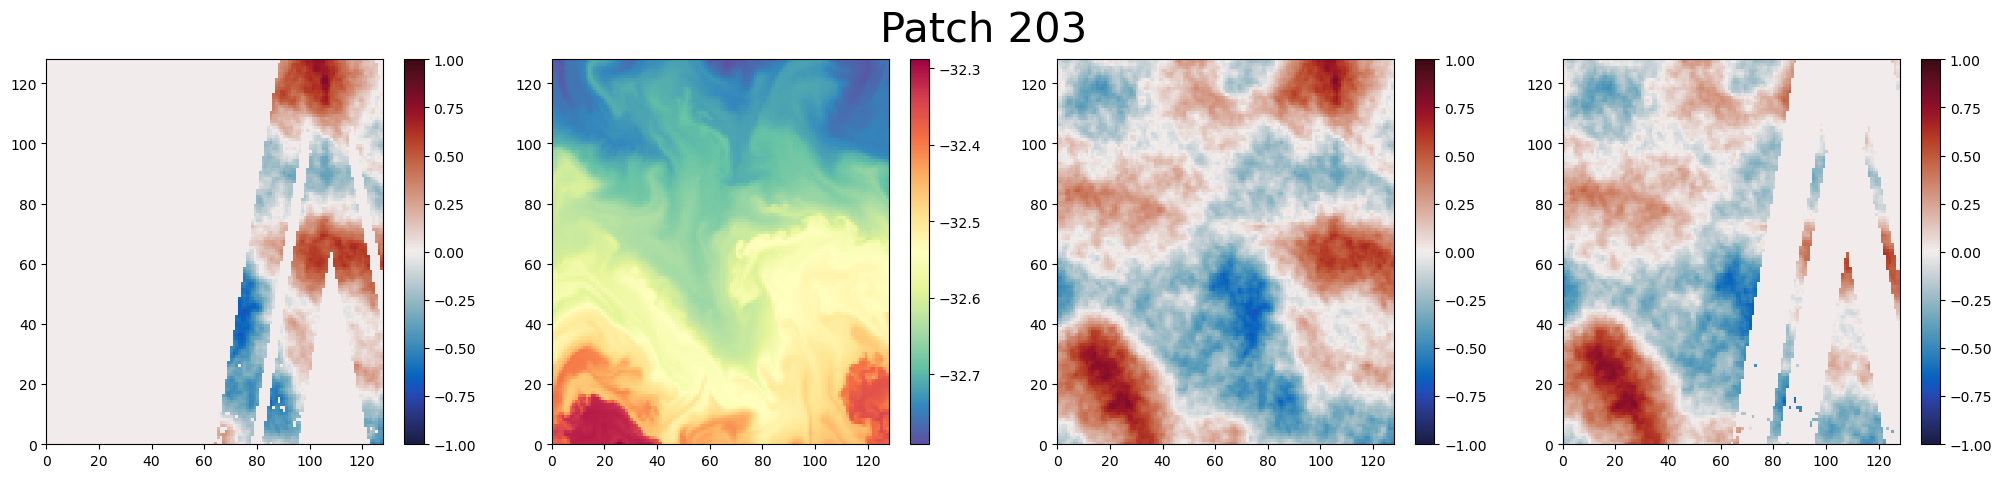

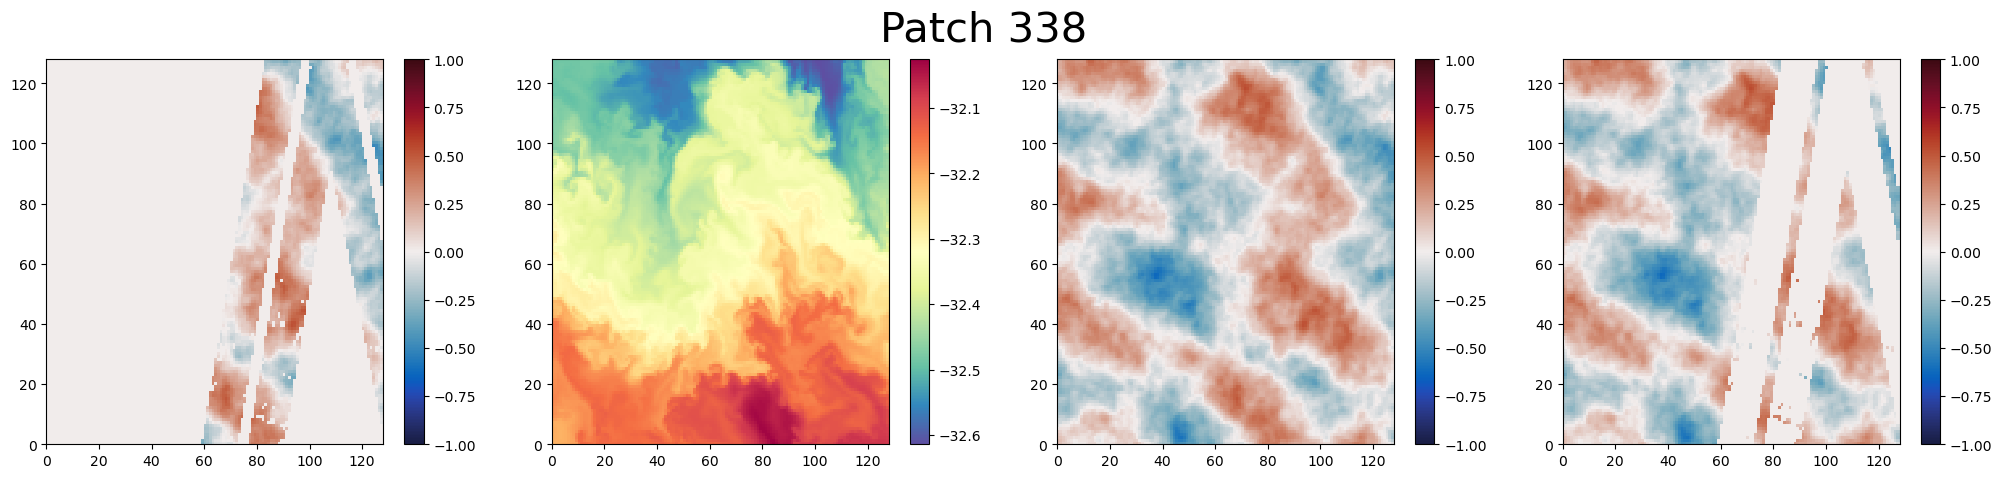

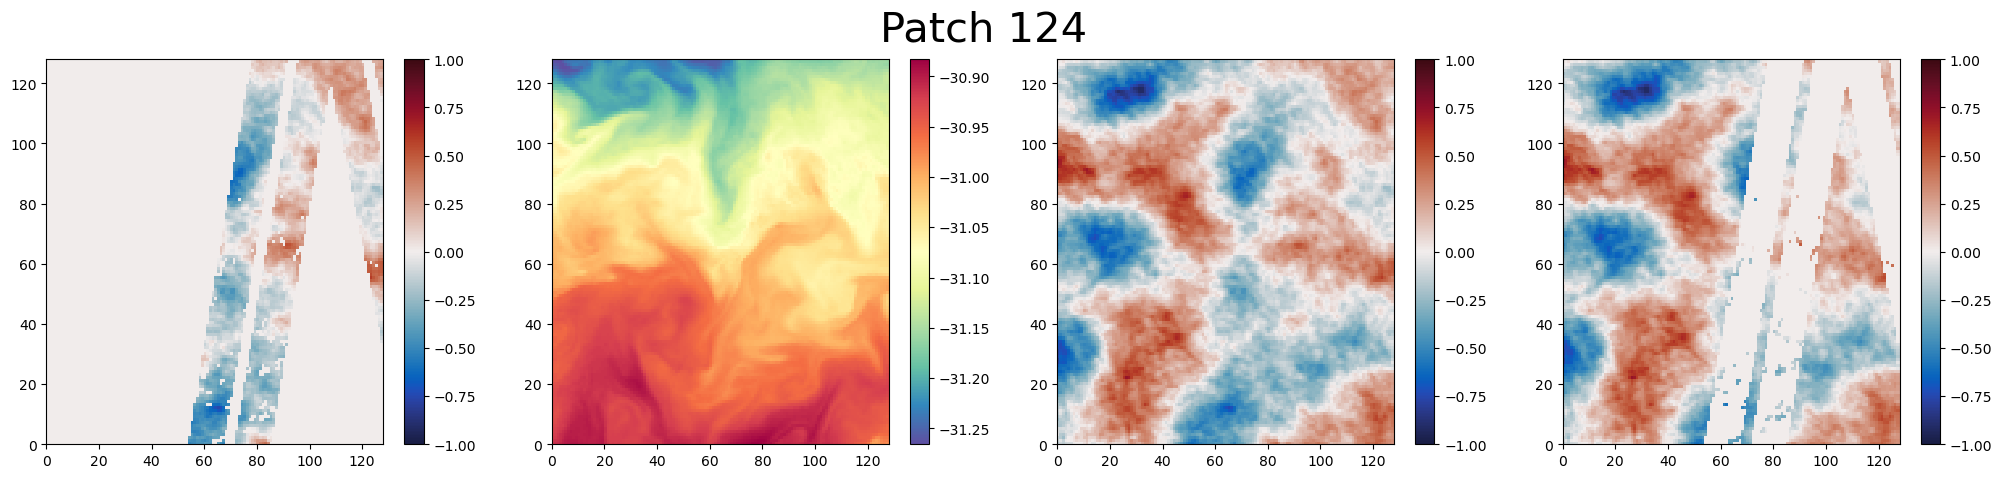

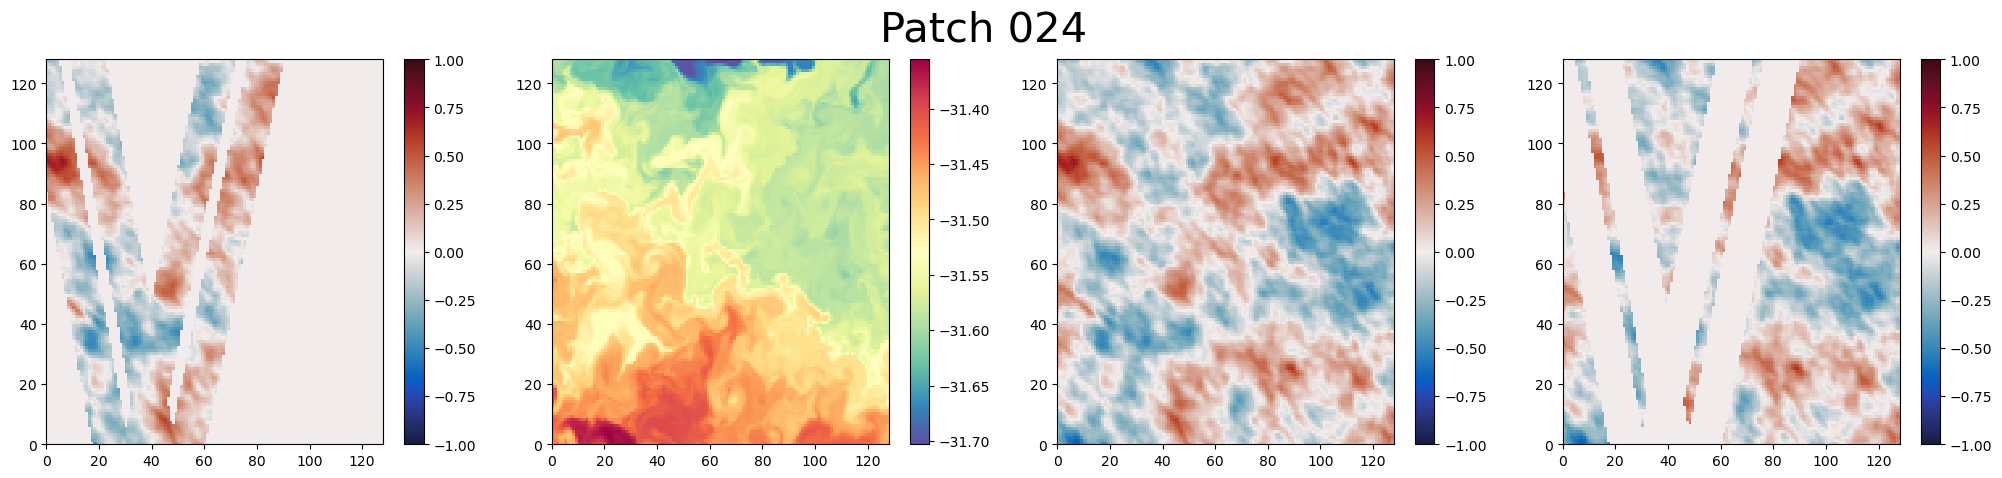

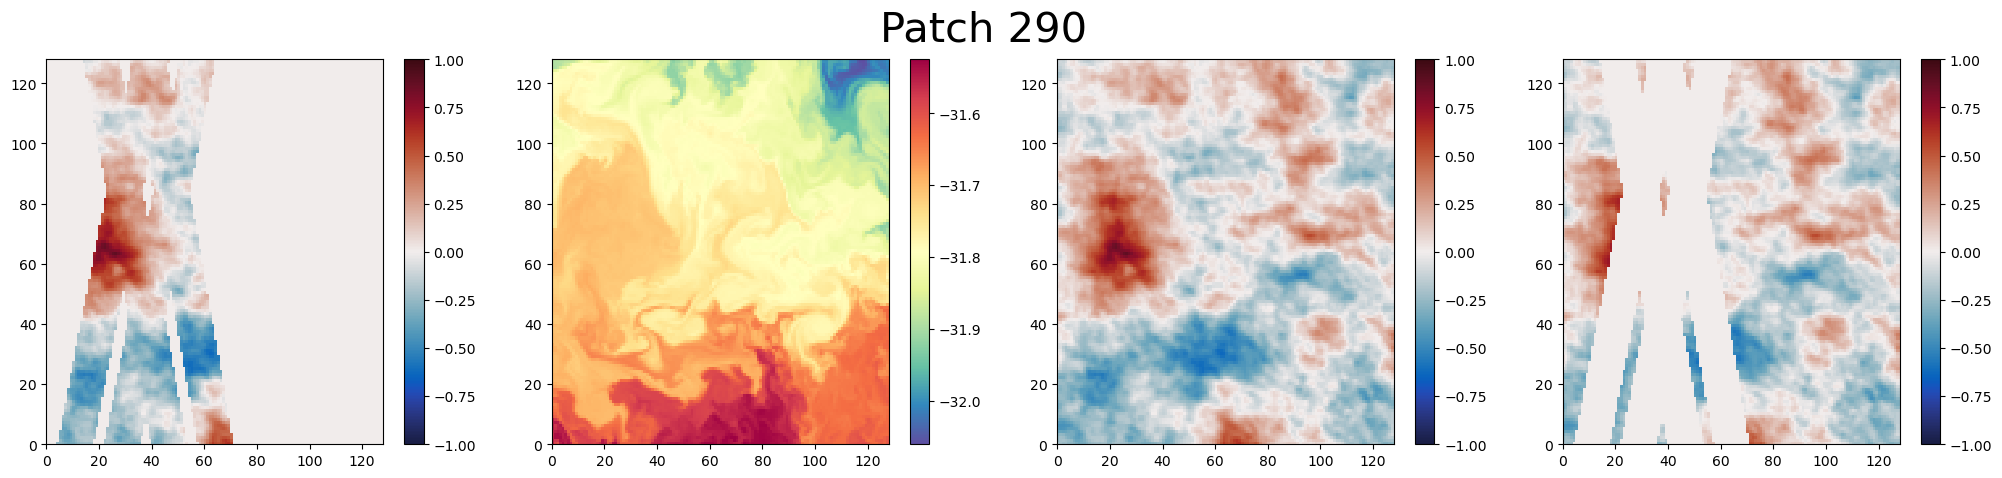

In [106]:
for i in range(len(x)):
    fig, axs = plt.subplots(1,4,figsize=(35,5))
    ims = [axs[0].pcolor(x[i,10,0,:,:],cmap=cm.cm.balance,vmin=-1,vmax=1),
           axs[1].pcolor(x[i,10,1,:,:],cmap="Spectral_r"),
           axs[2].pcolor(y[i,10,0,:,:],cmap=cm.cm.balance,vmin=-1,vmax=1),
           axs[3].pcolor(y[i,10,0,:,:]-x[i,10,0,:,:],cmap=cm.cm.balance,vmin=-1,vmax=1),
           axs[4].pcolor(y[i,10,0,:,:]-x[i,10,0,:,:],cmap=cm.cm.balance,vmin=-1,vmax=1)]
    for j, im in enumerate(ims):
        fig.colorbar(im,ax=axs[j])
    fig.suptitle(f"Patch {metadata["patch_ID"][i]}",fontsize=30)
    plt.show()
    plt.close()
    

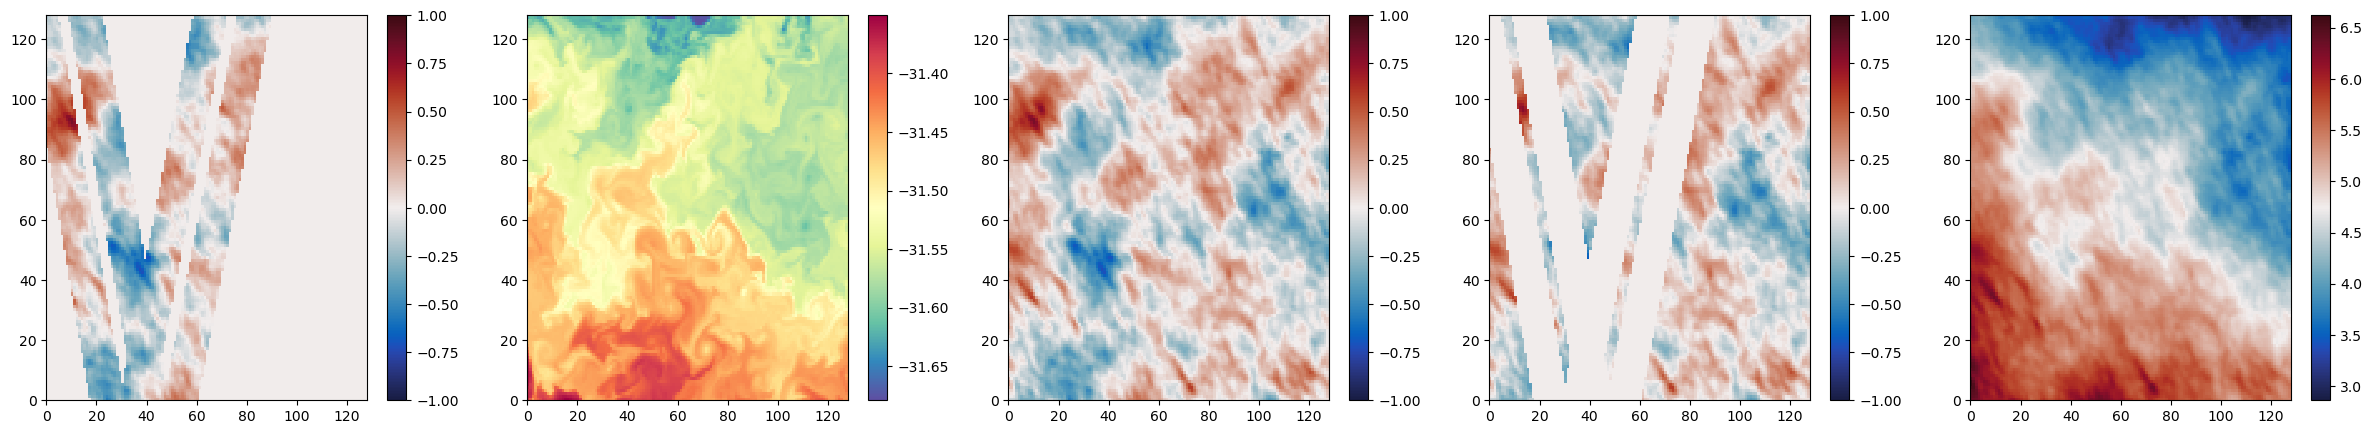

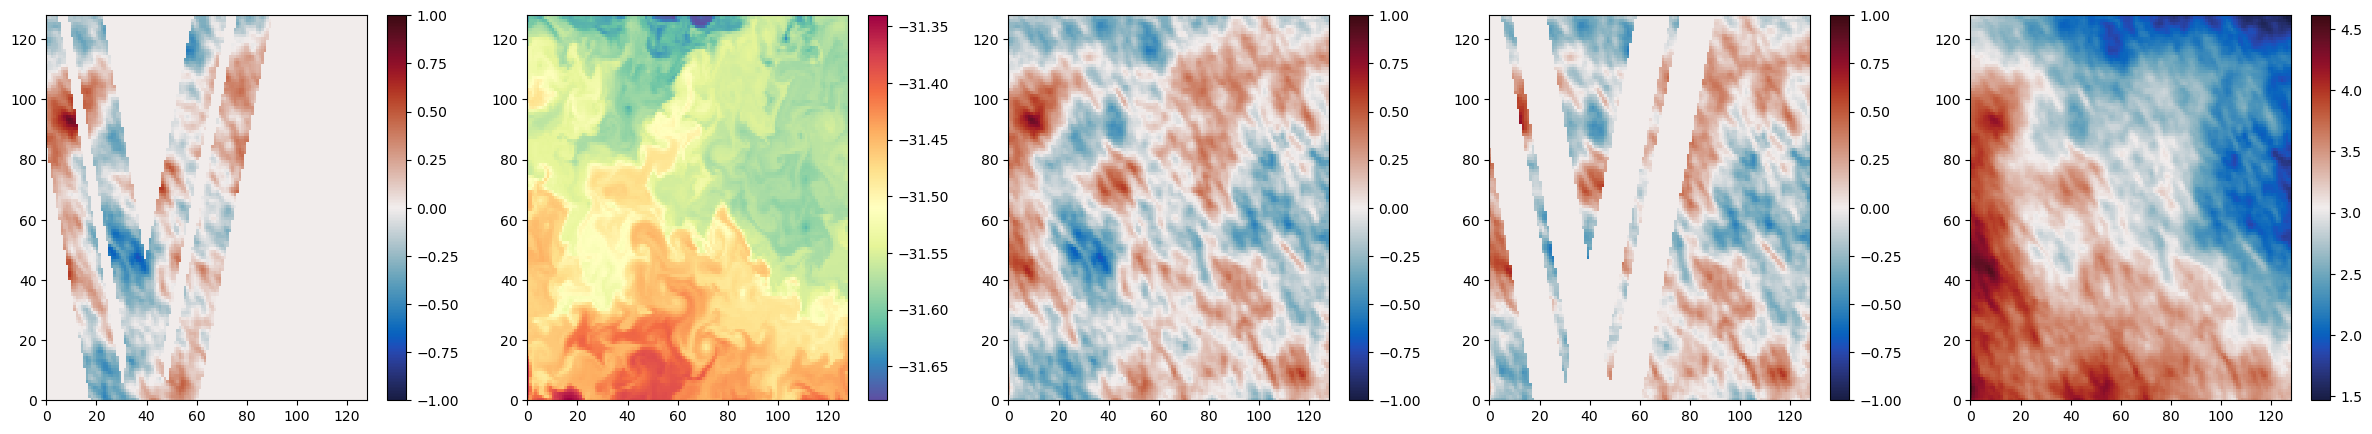

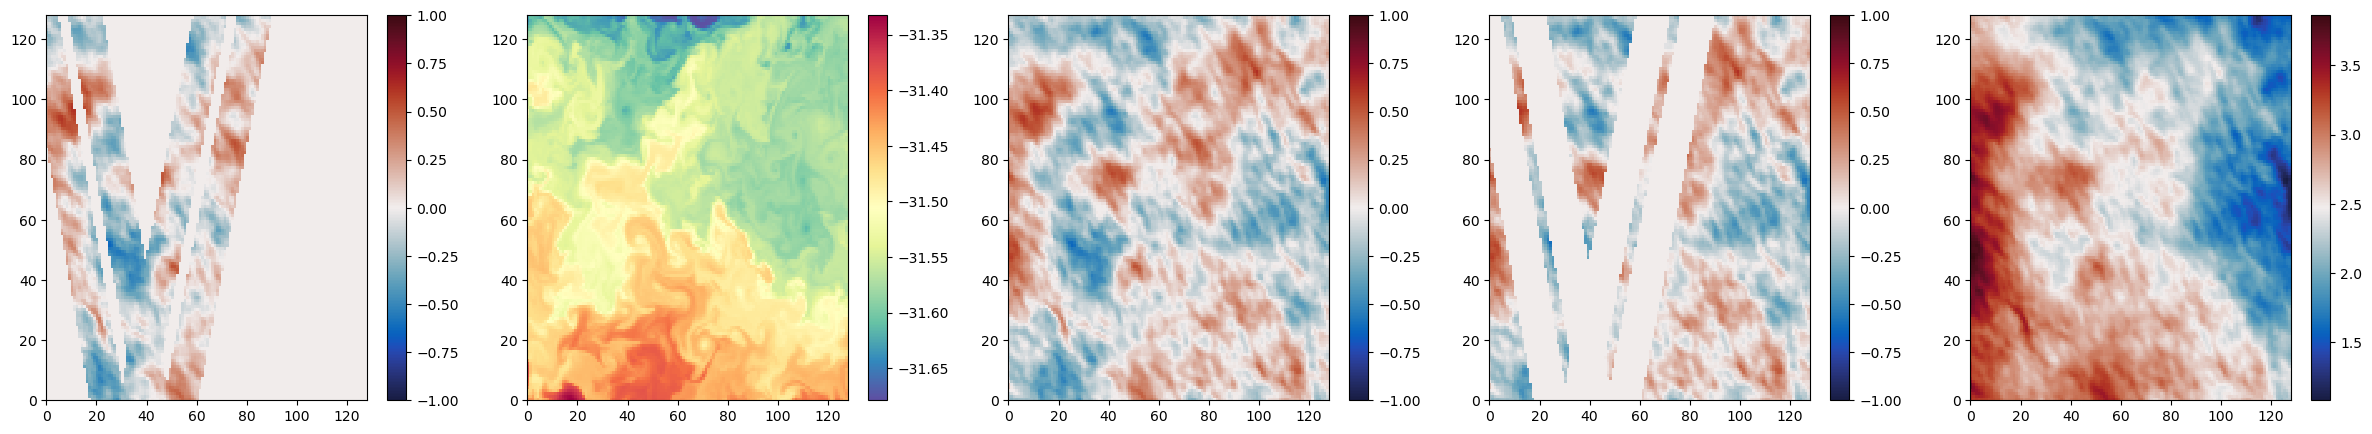

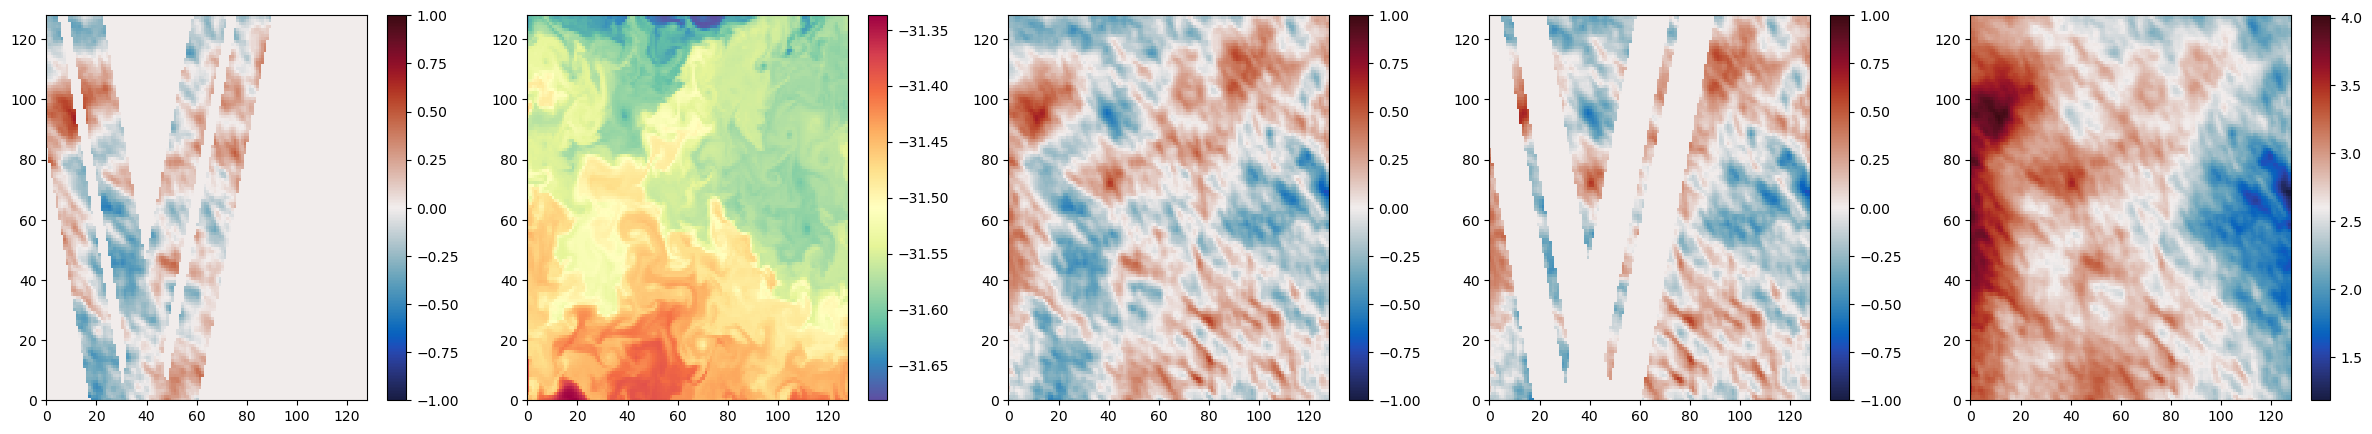

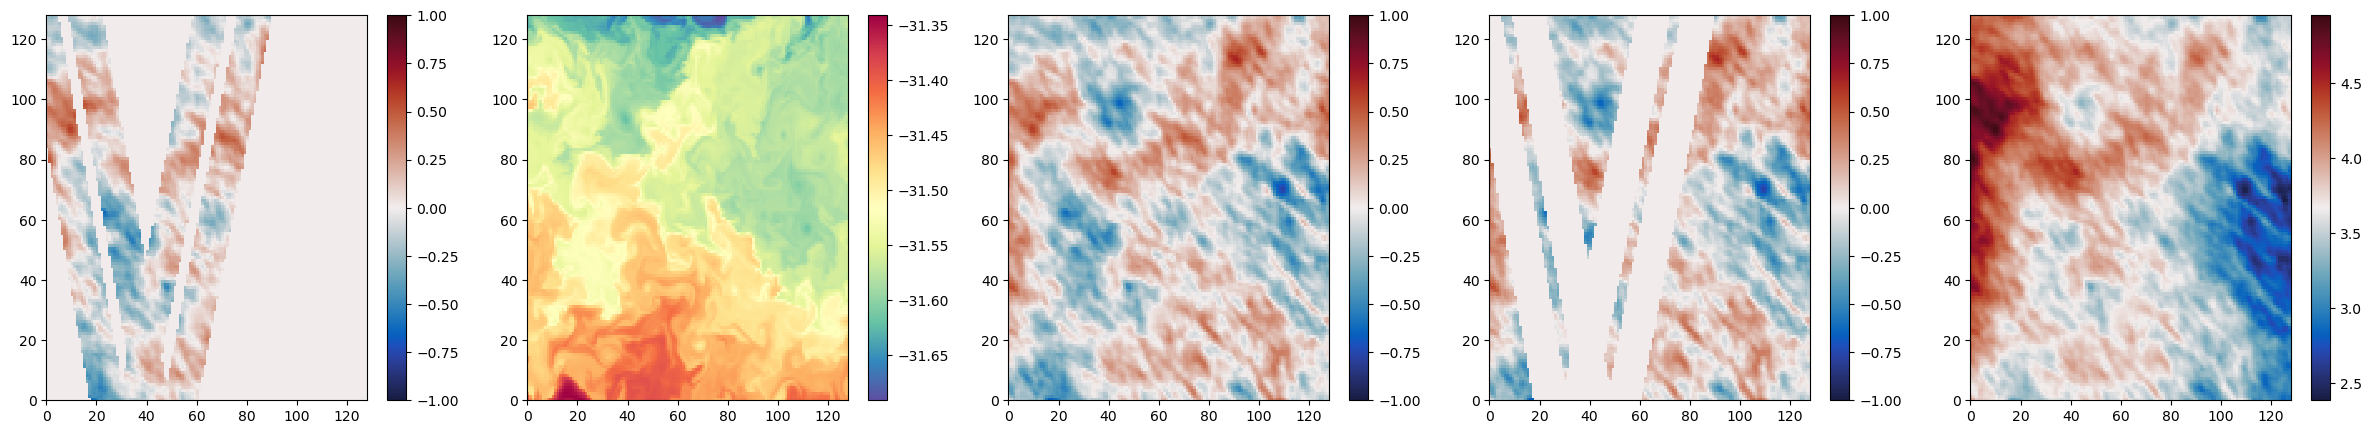

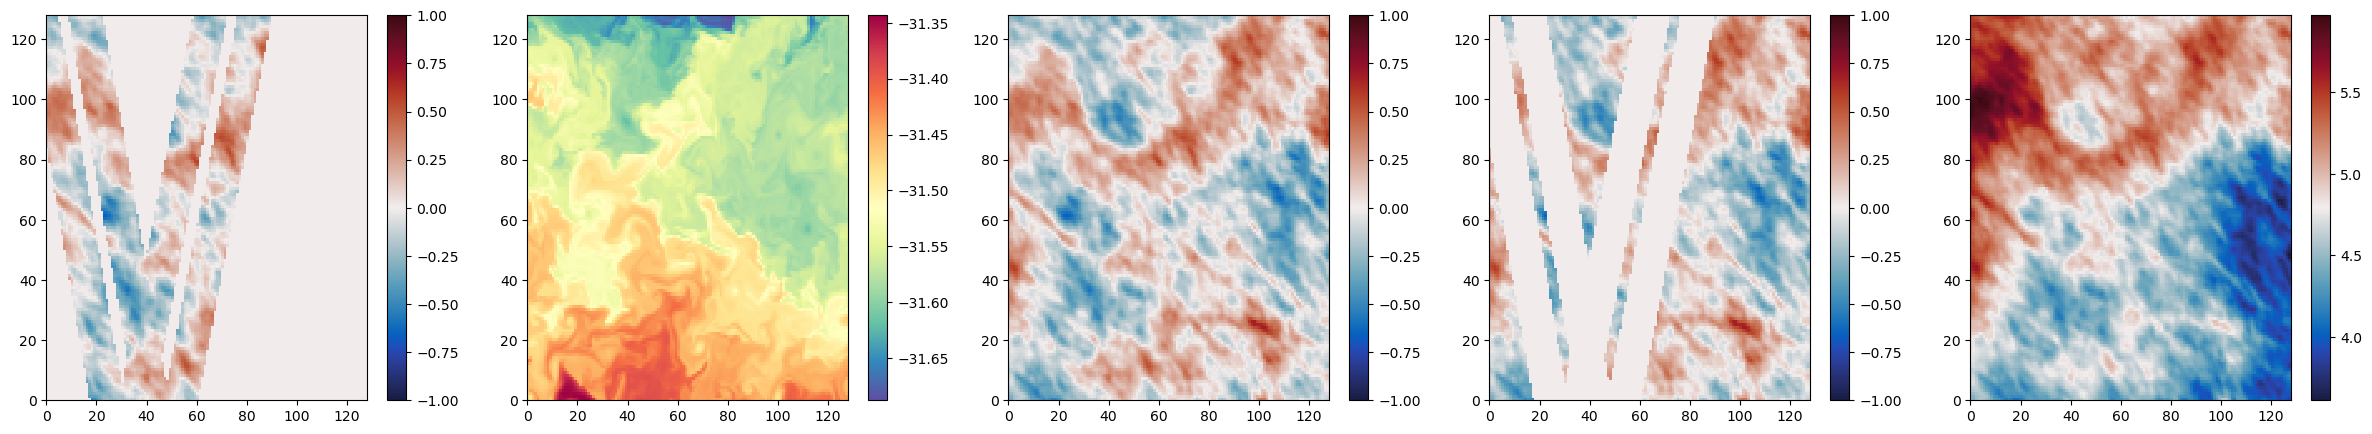

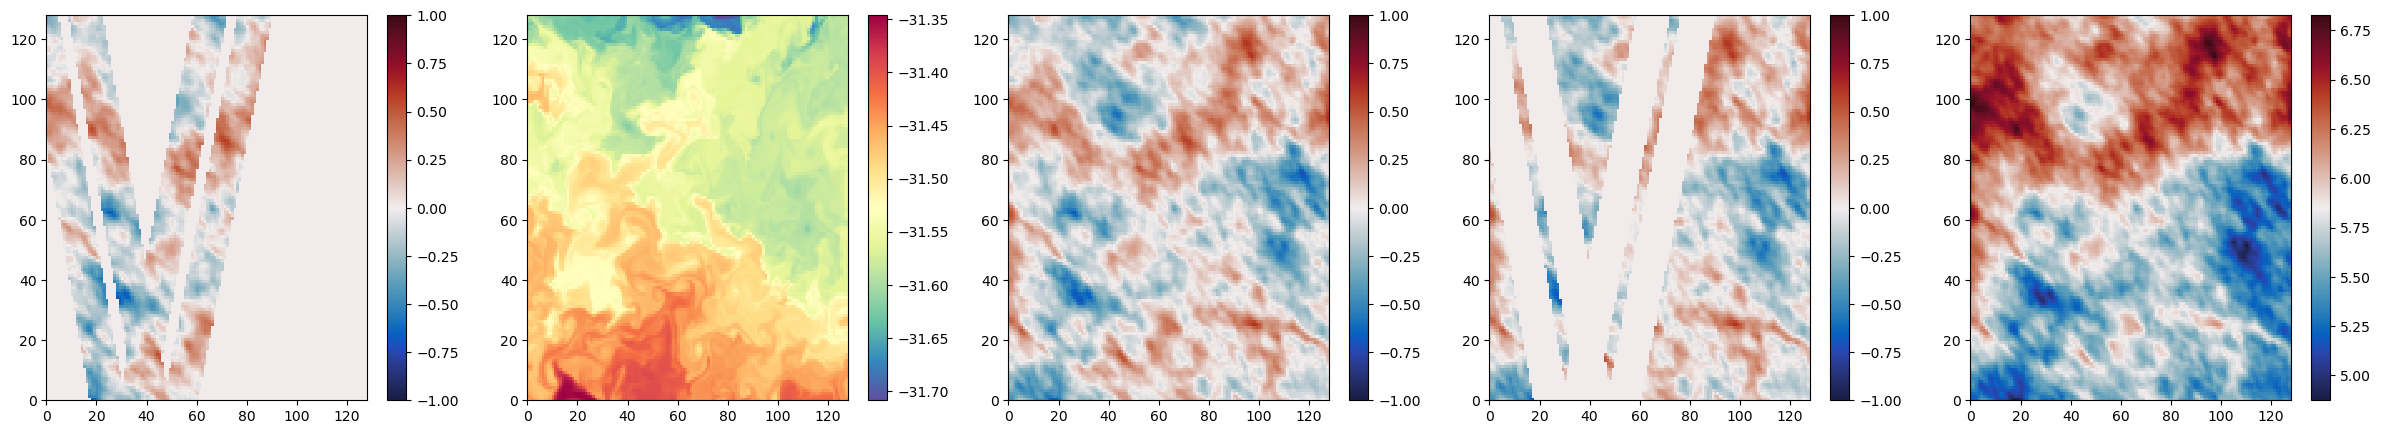

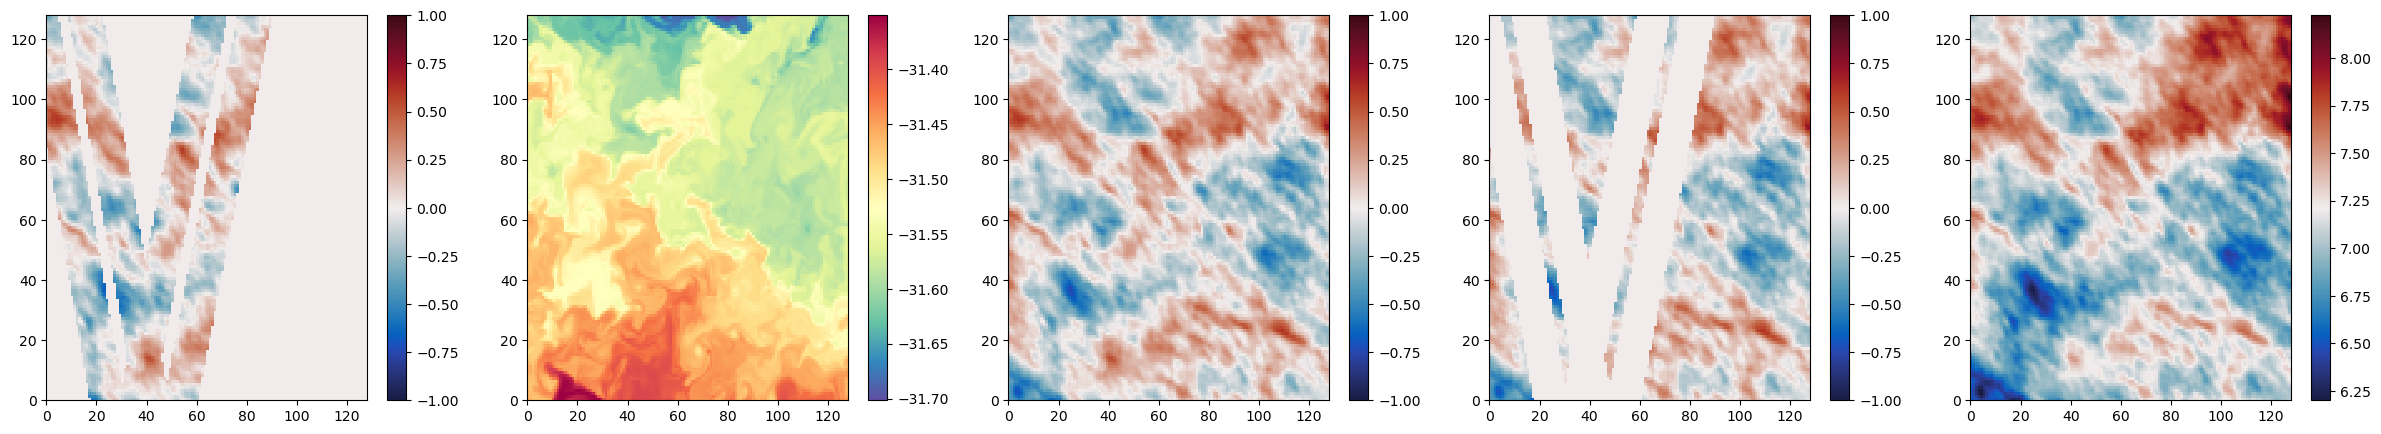

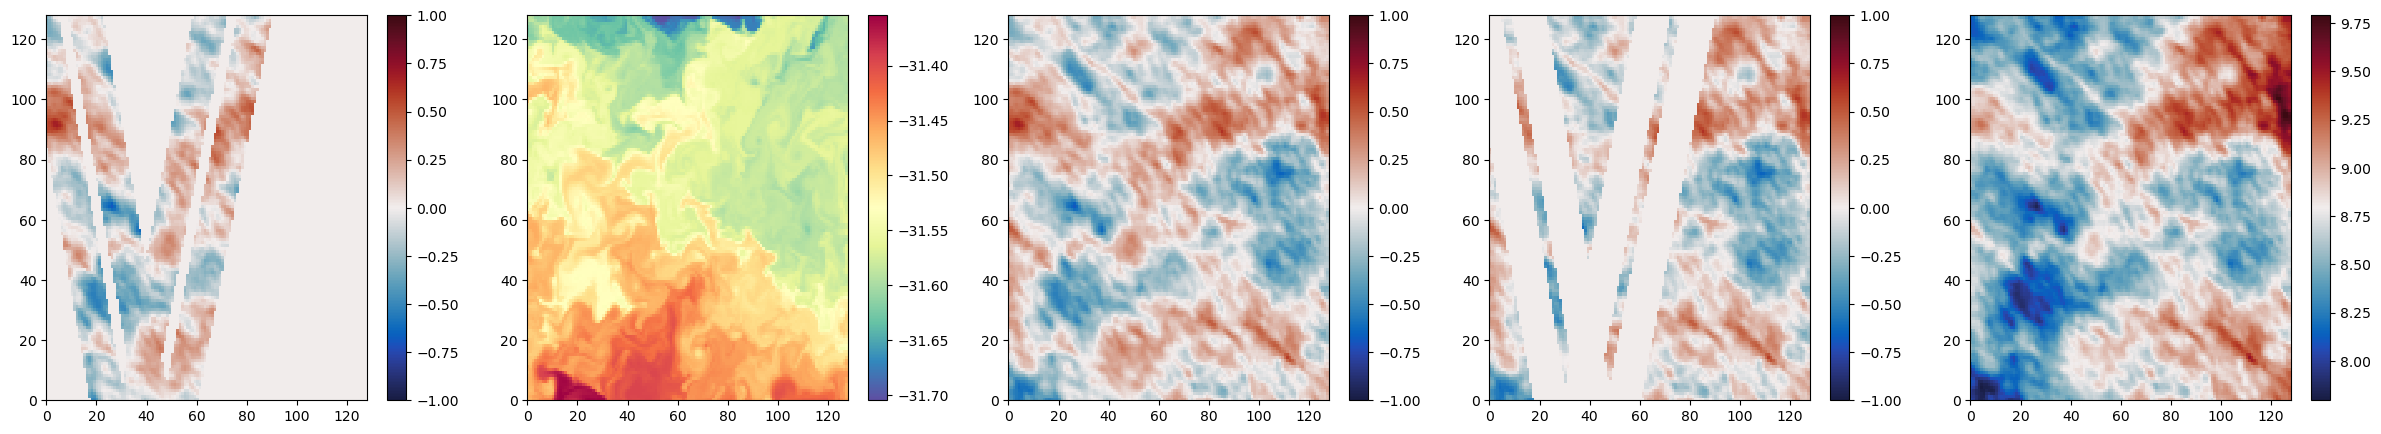

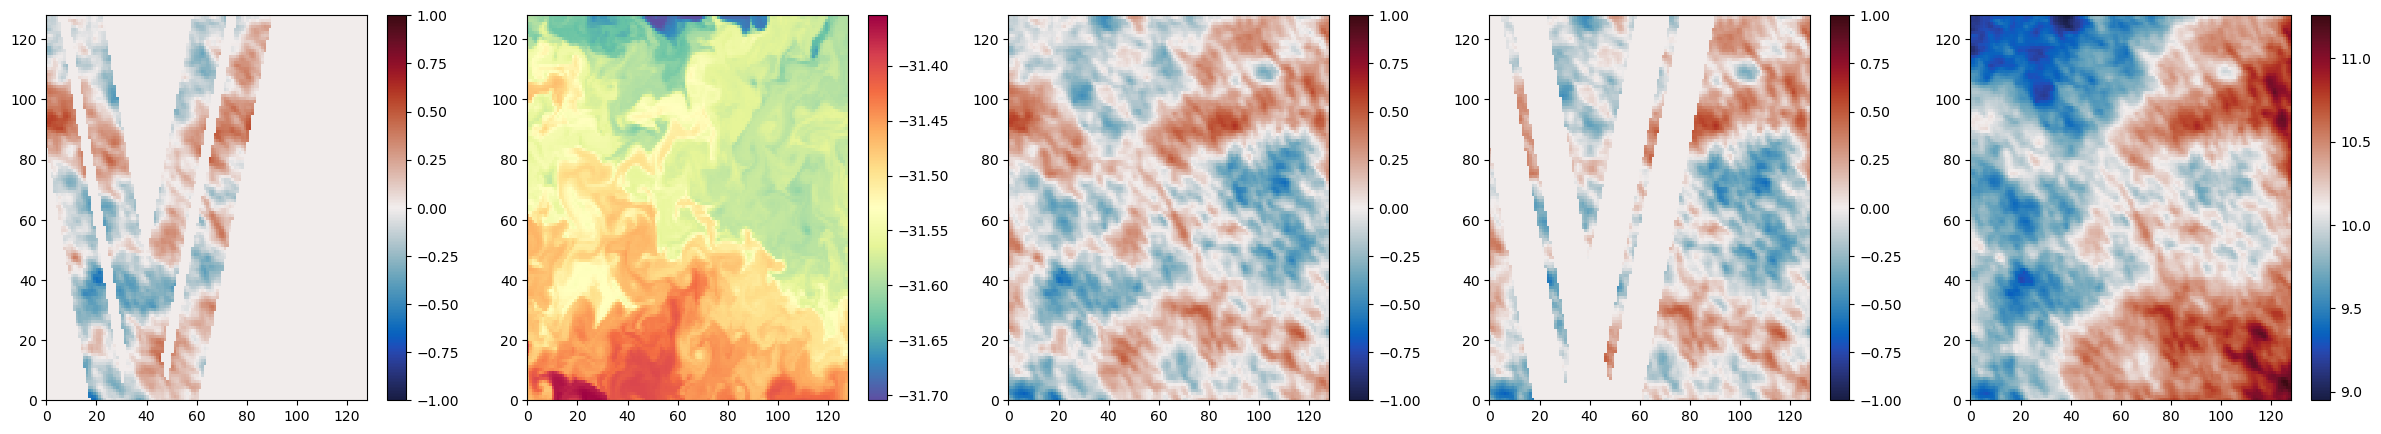

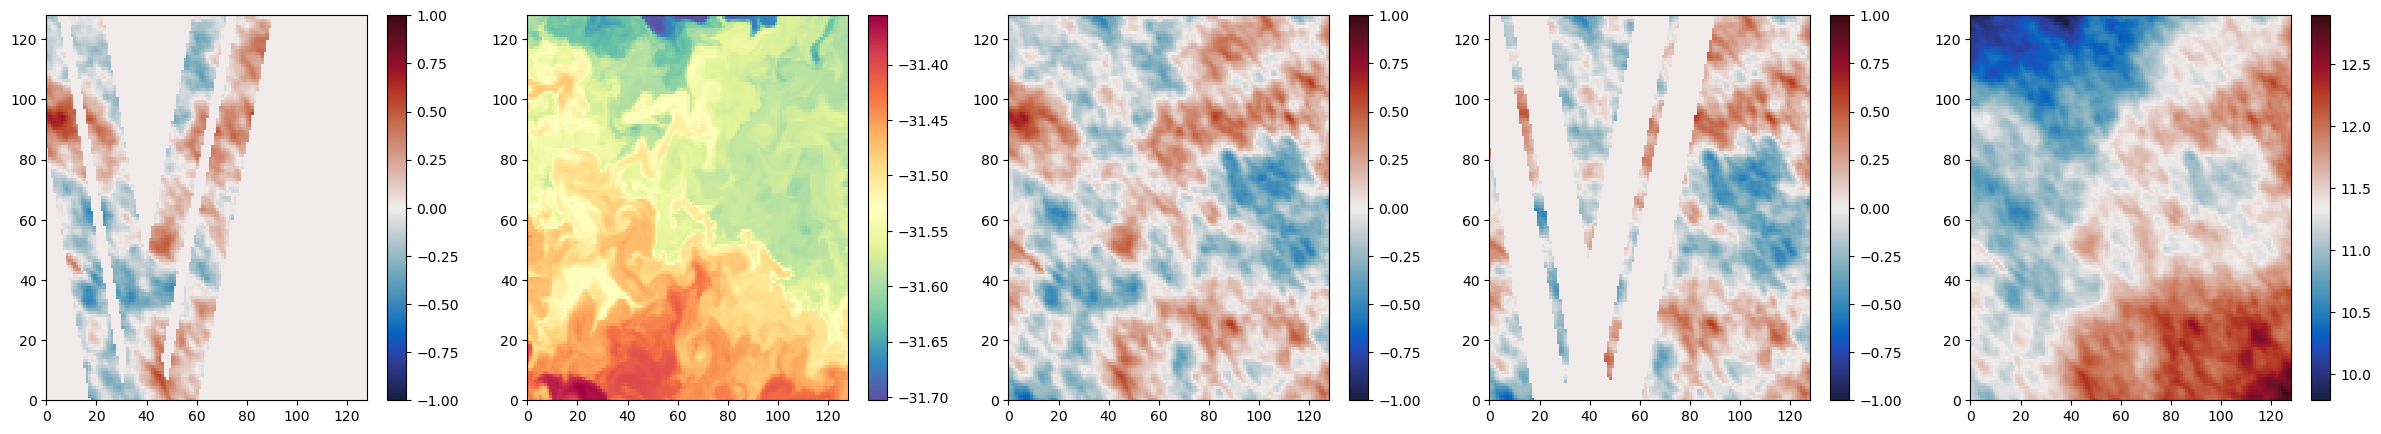

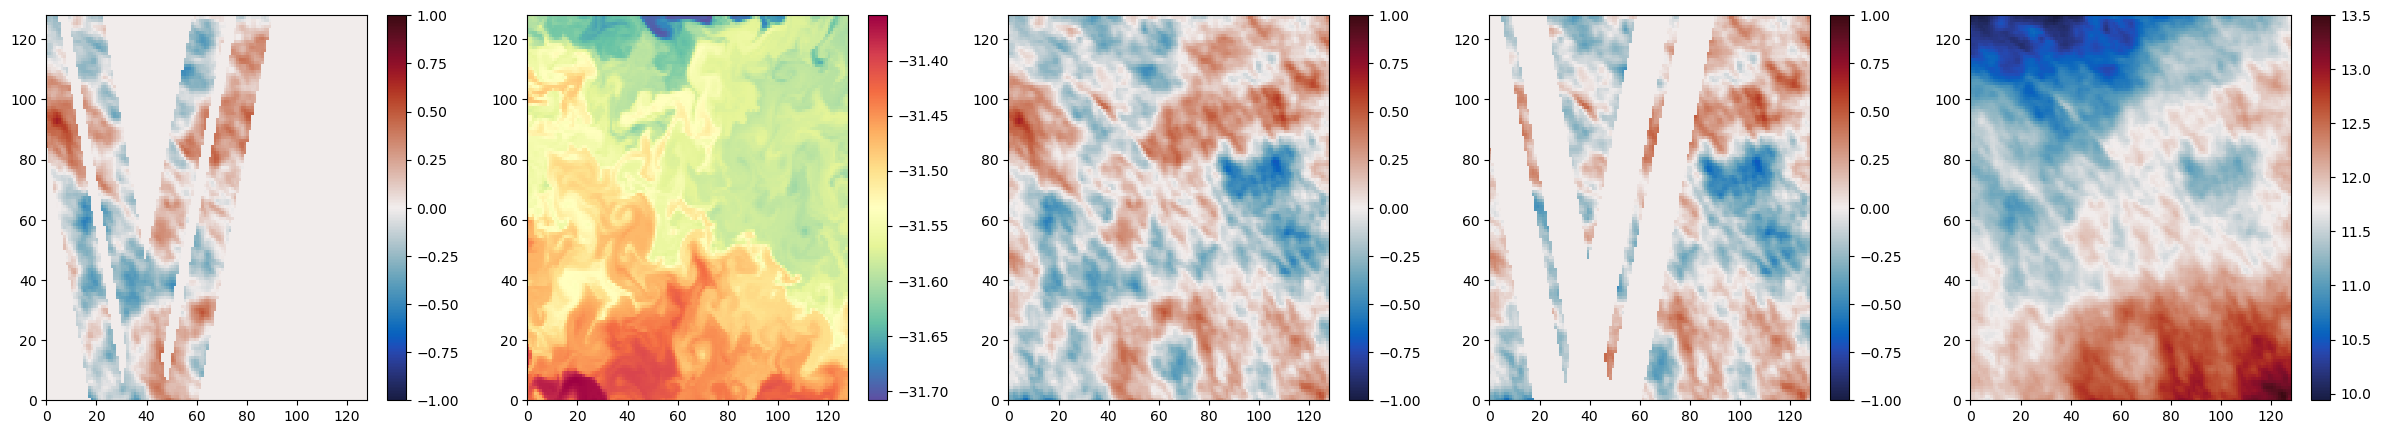

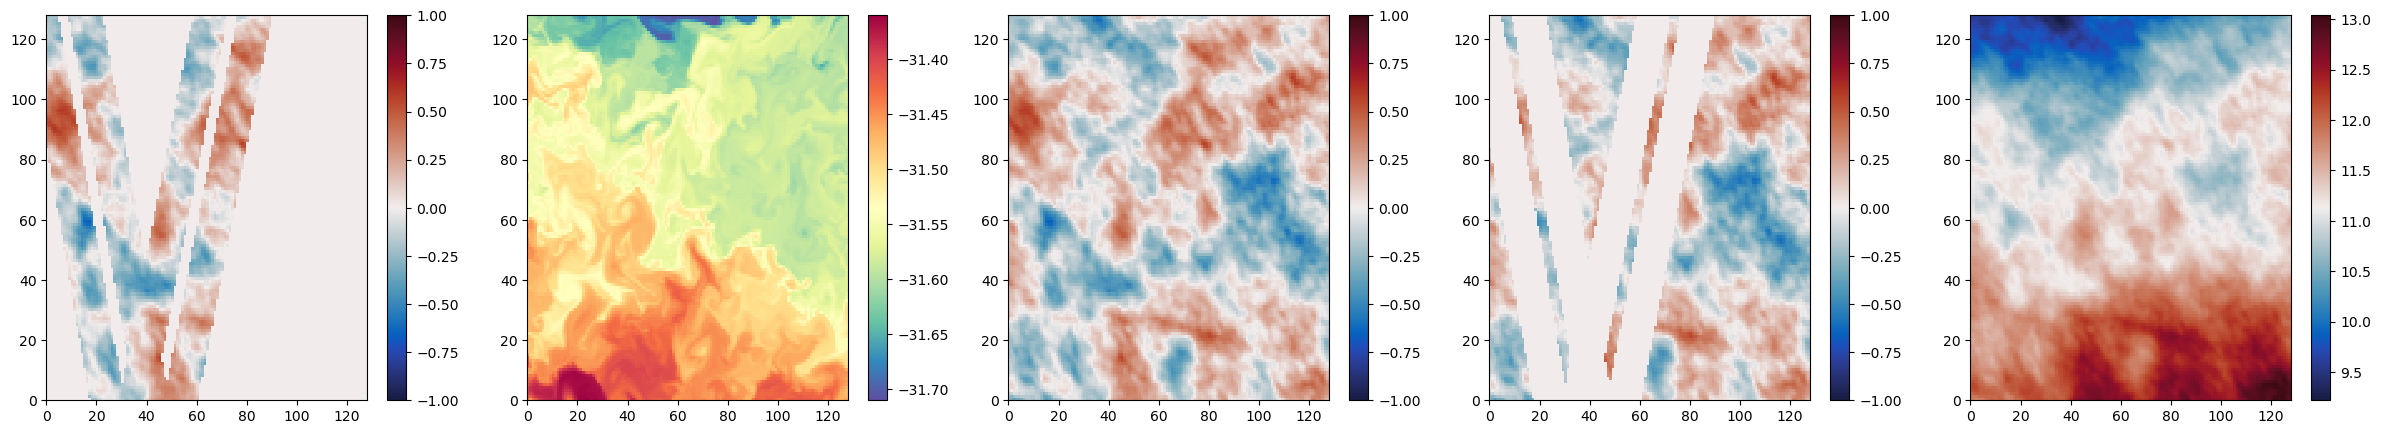

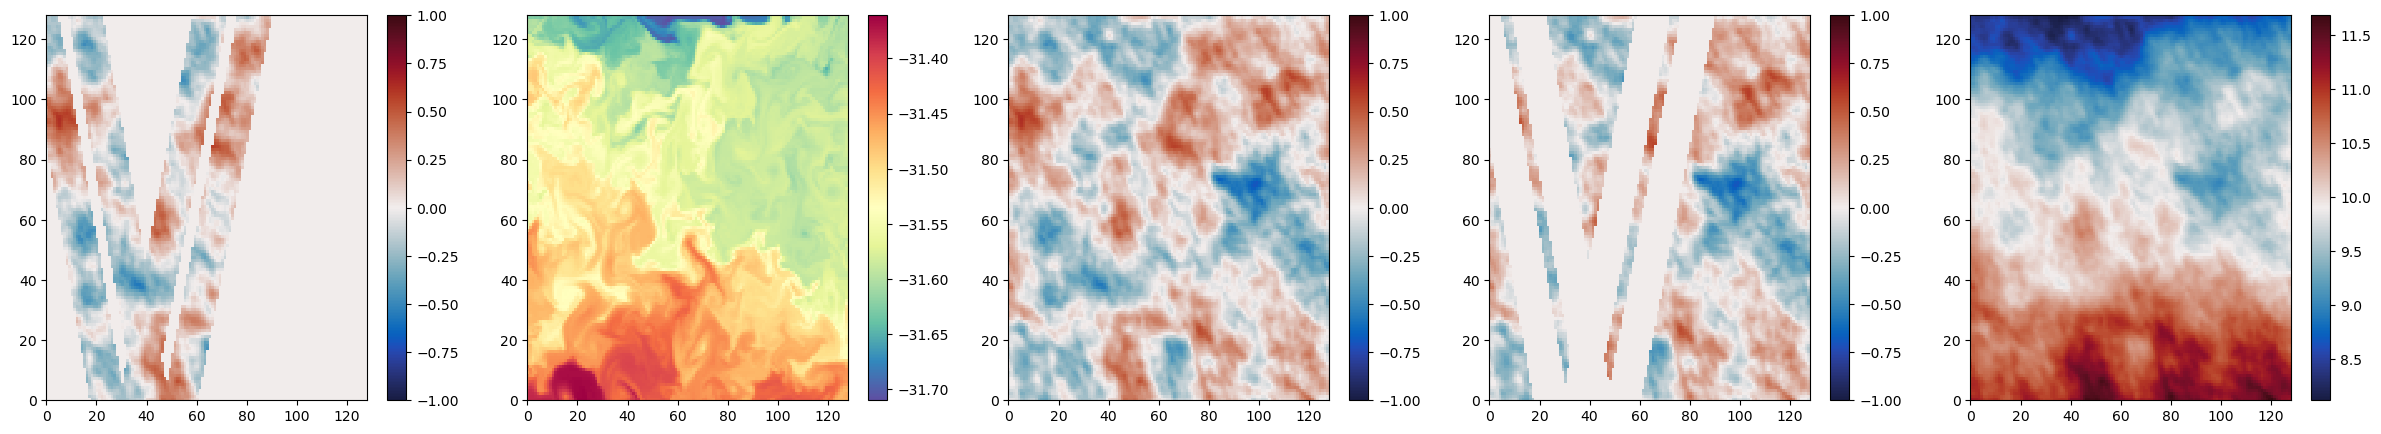

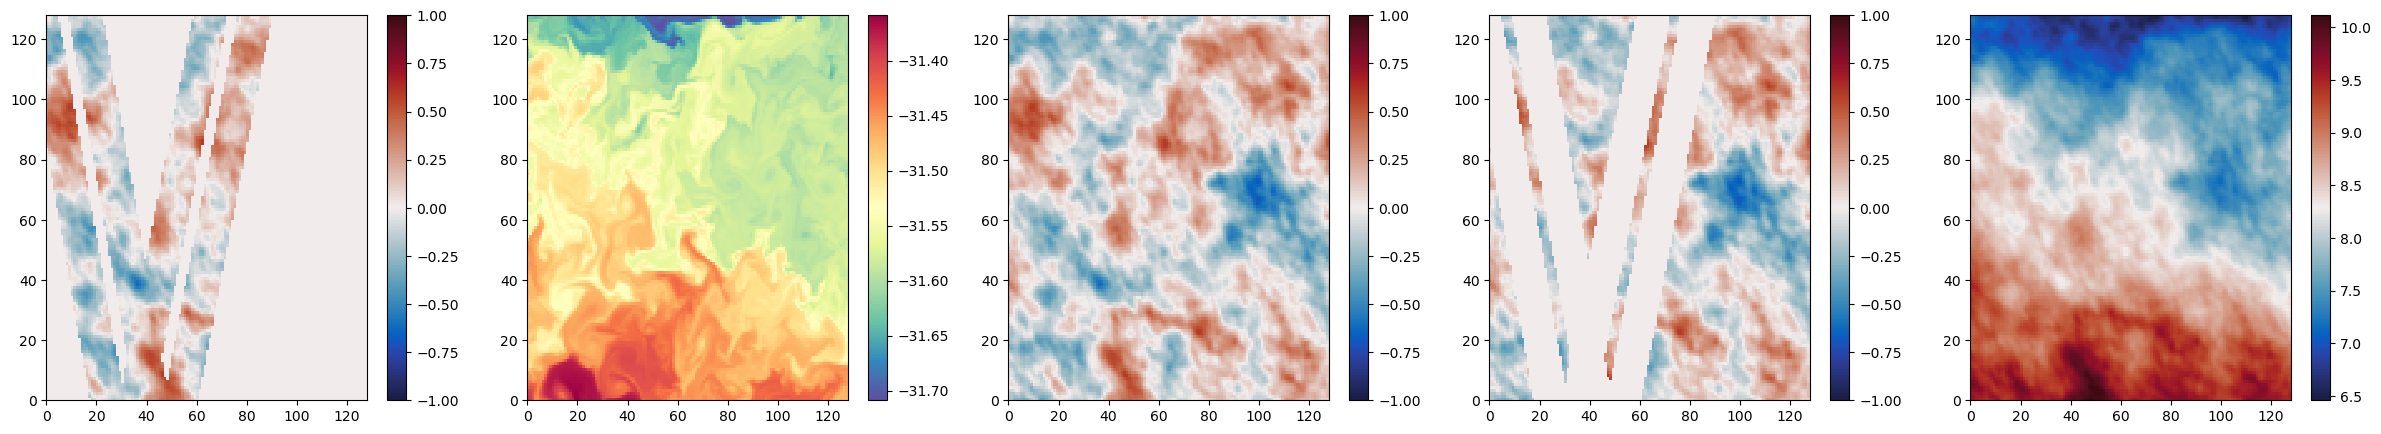

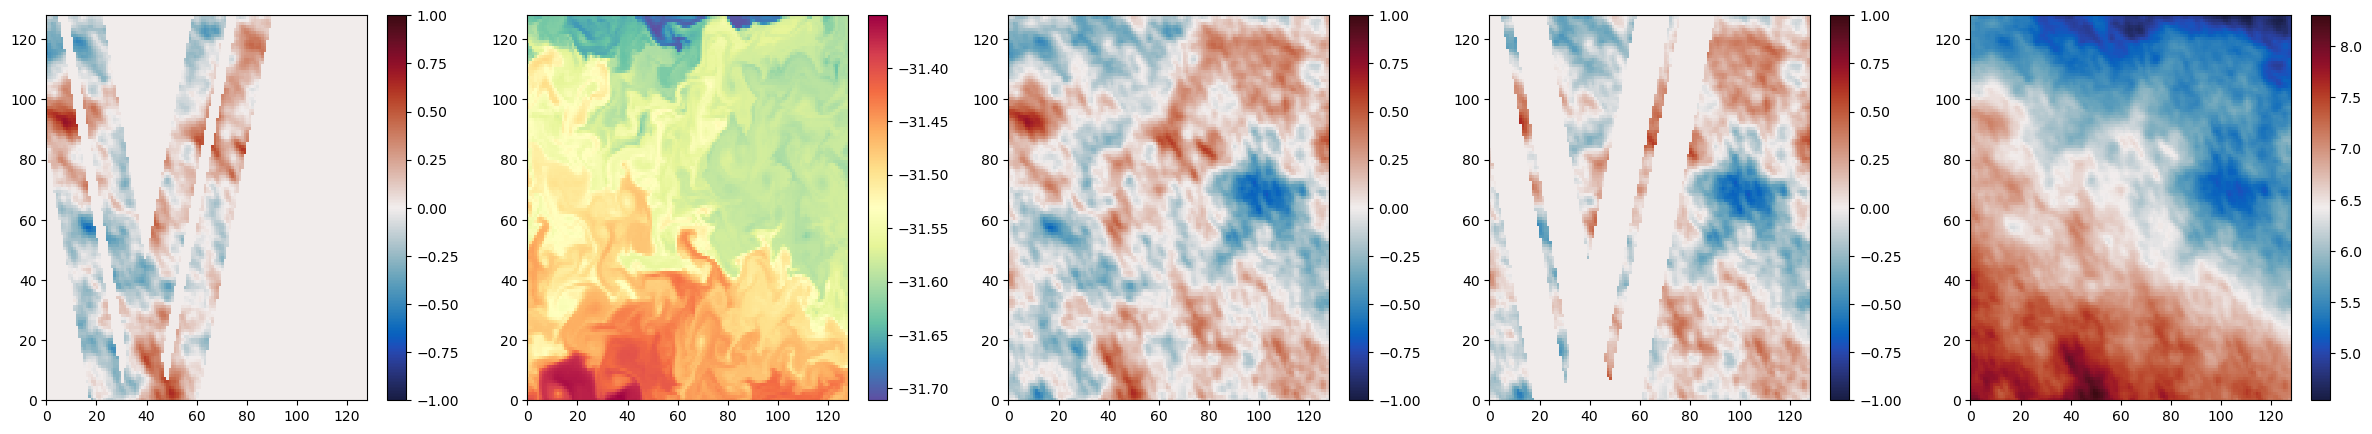

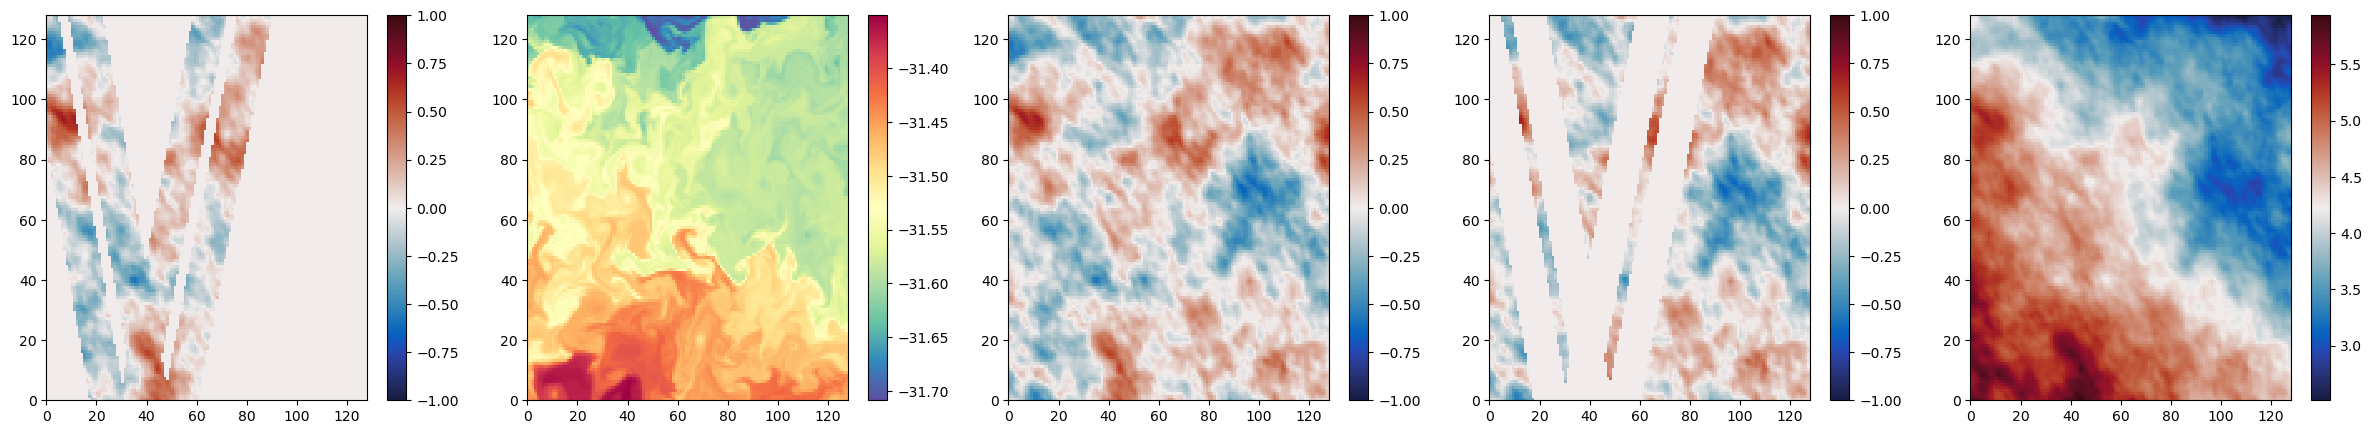

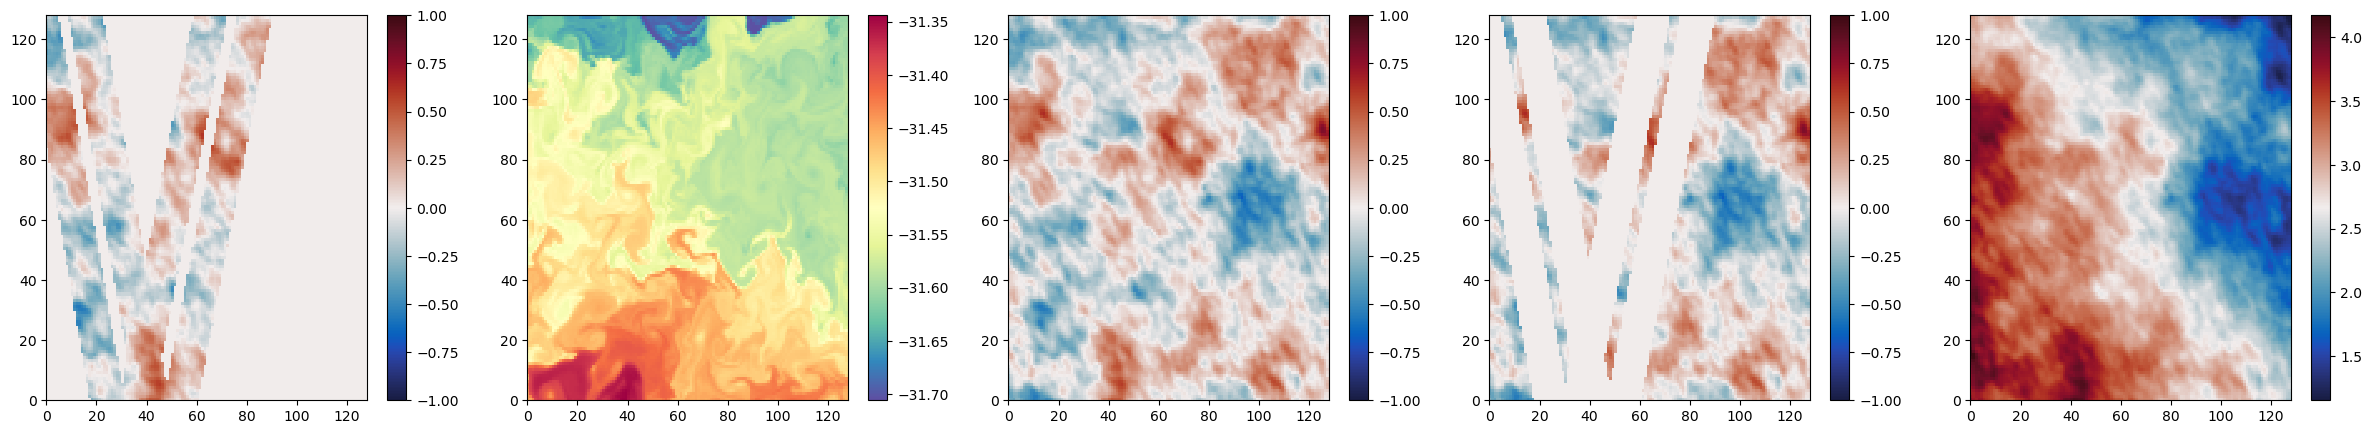

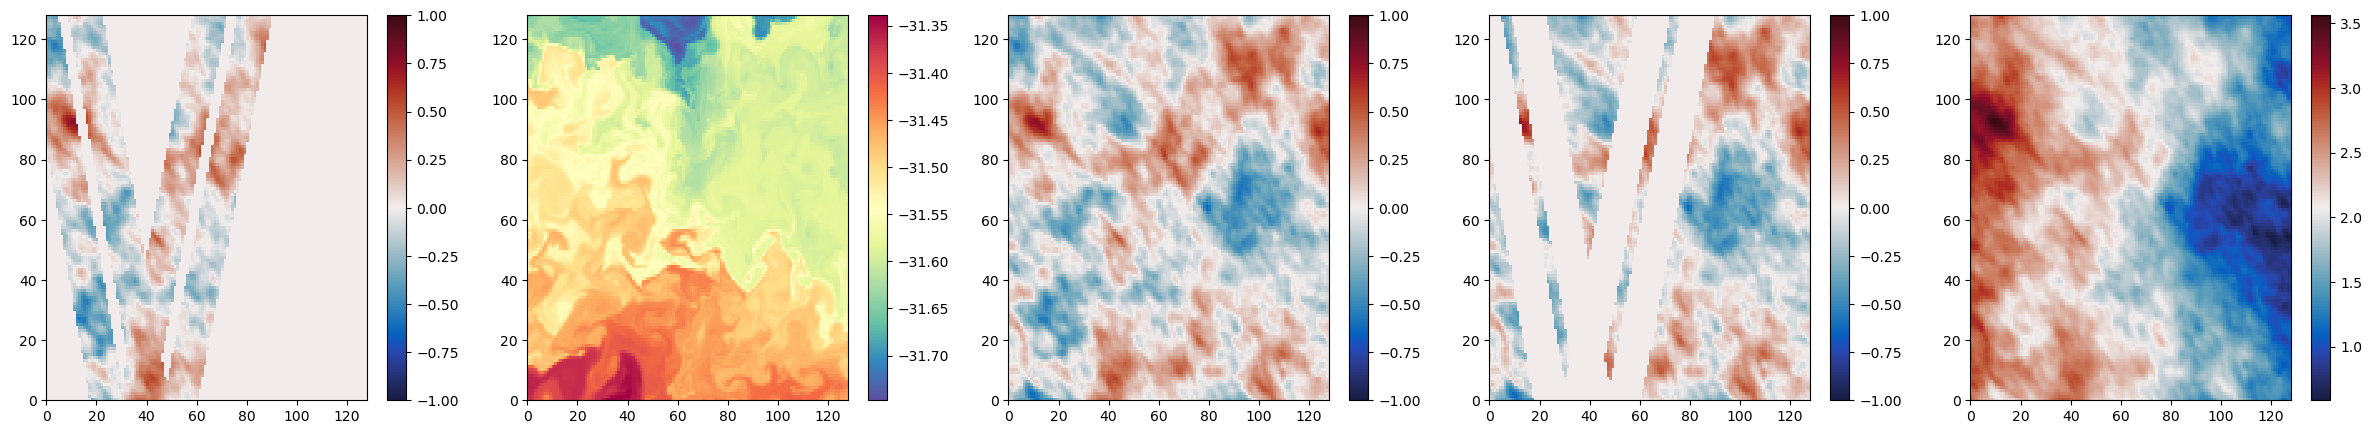

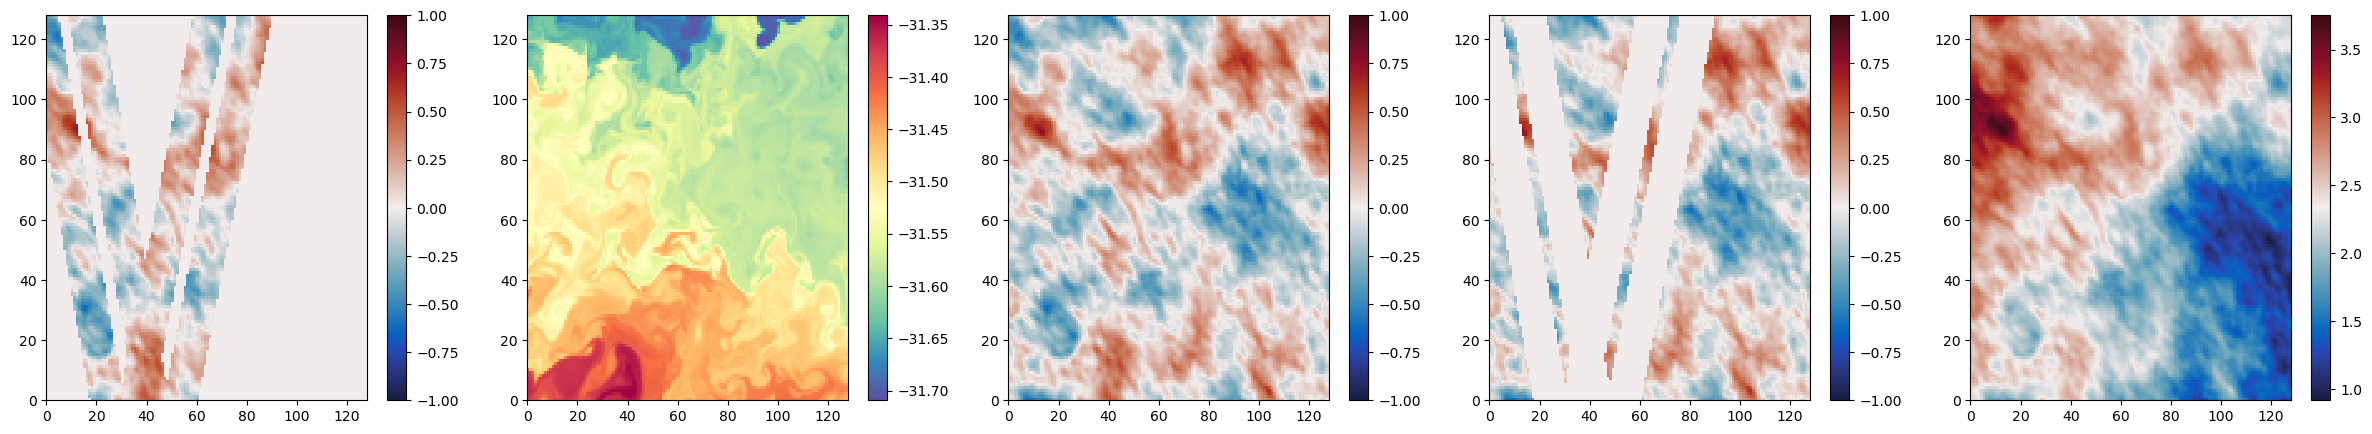

In [110]:
patch_i = 3

for t in range(len(x[patch_i])):
    fig, axs = plt.subplots(1,5,figsize=(30,5))
    ims = [axs[0].pcolor(x[patch_i,t,0,:,:],cmap=cm.cm.balance,vmin=-1,vmax=1),
           axs[1].pcolor(x[patch_i,t,1,:,:],cmap="Spectral_r"),
           axs[2].pcolor(y[patch_i,t,0,:,:],cmap=cm.cm.balance,vmin=-1,vmax=1),
           axs[3].pcolor(y[patch_i,t,0,:,:]-x[patch_i,t,0,:,:],cmap=cm.cm.balance,vmin=-1,vmax=1),
           axs[4].pcolor(y[patch_i,t,1,:,:],cmap=cm.cm.balance),
          ]
    for j, im in enumerate(ims):
        fig.colorbar(im,ax=axs[j])
    plt.show()
    plt.close()

# Do some jaxparrow stuff

In [ ]:
import jaxparrow
from jaxparrow.tools.kinematics import magnitude

In [ ]:
metadata["latitude"].shape

# Calculate geostrophic and cyclstrophic velocities

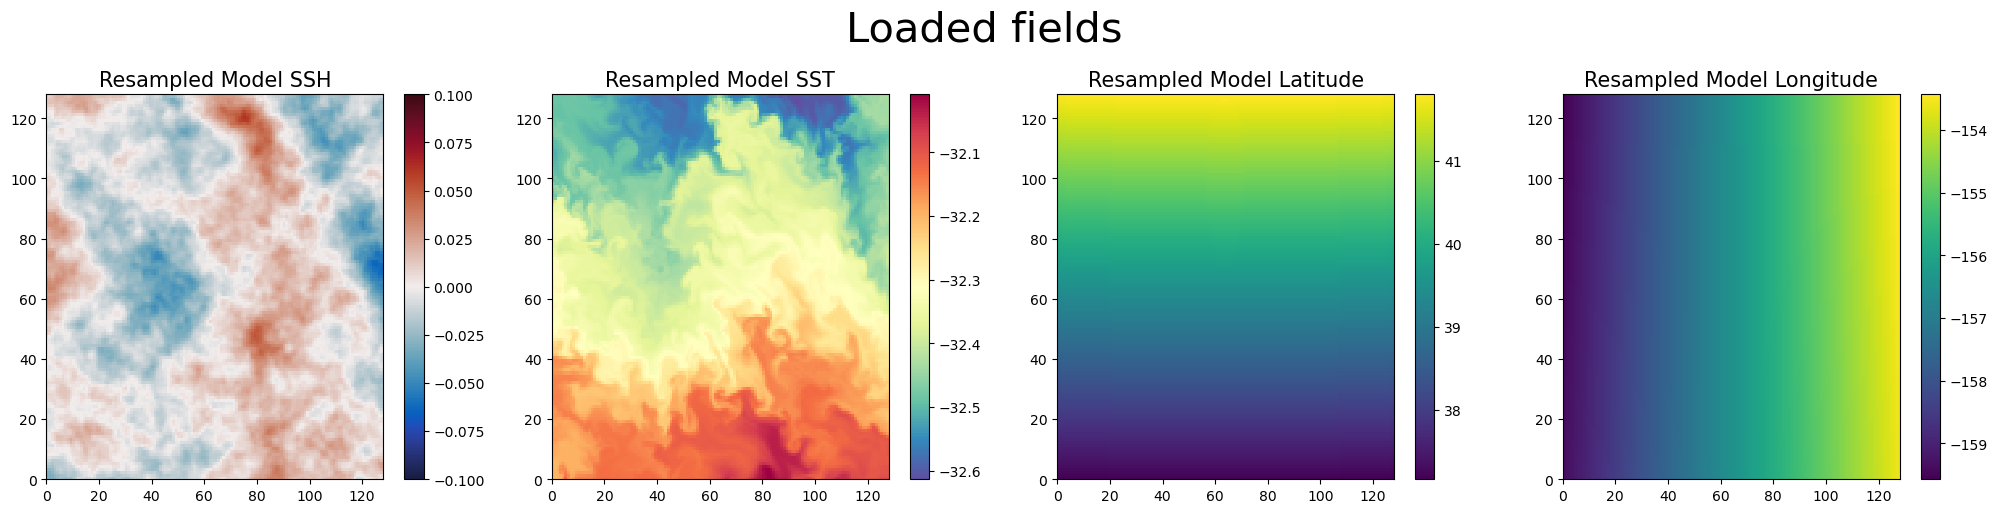

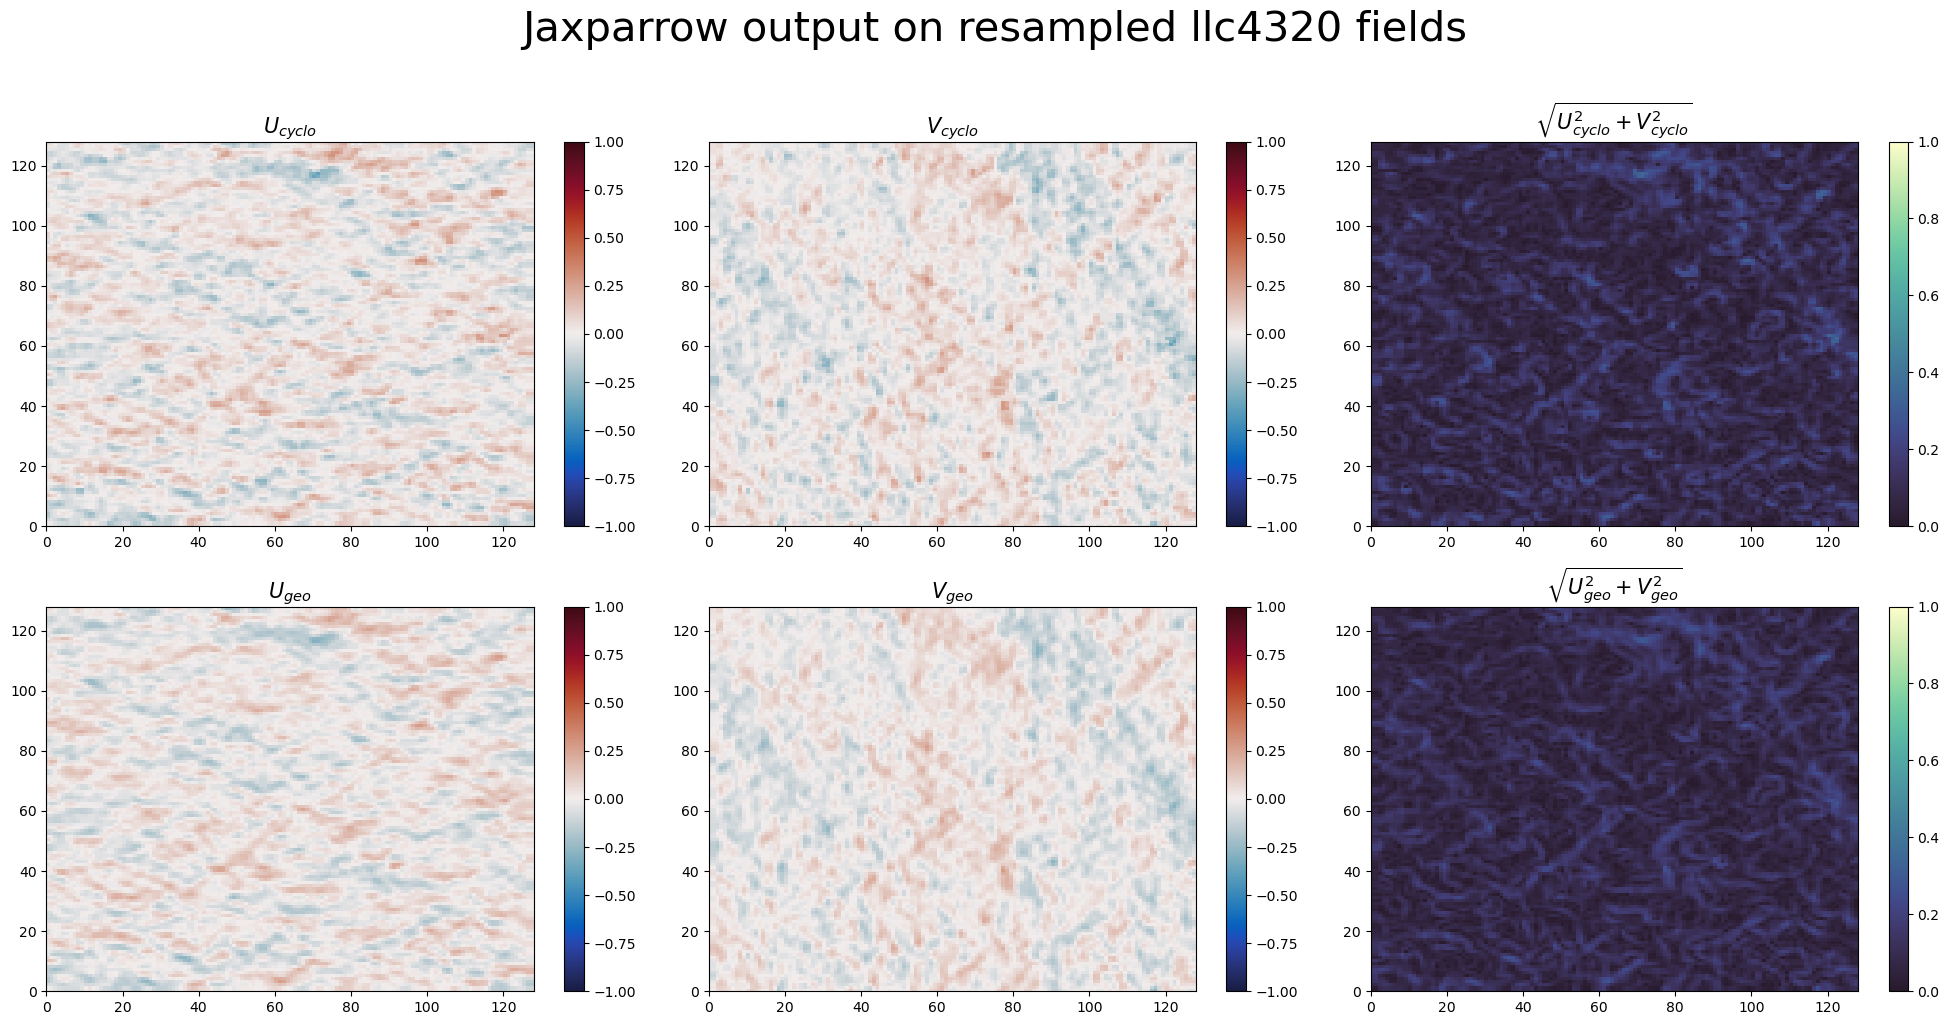

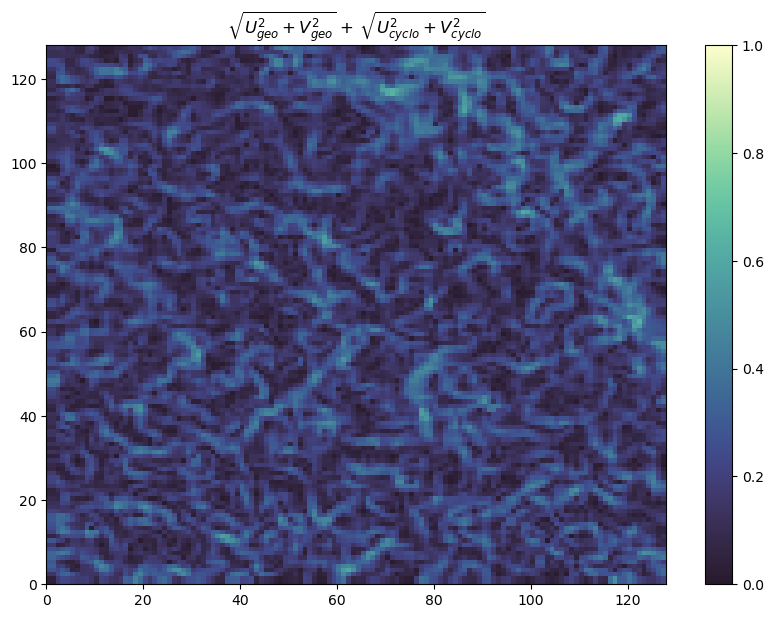

In [40]:
patch_i = 1

sst_in = np.asarray(x[patch_i,t,1,:,:])
ssh_target = np.asarray(y[patch_i,t,0,:,:])*std_ssh
latitude = np.asarray(metadata["latitude"][patch_i])
longitude = np.asarray(metadata["longitude"][patch_i])

cyclo_output = jaxparrow.cyclogeostrophy(ssh_target, latitude, longitude, return_geos=True, return_grids=False)
cyclo_magnitude = magnitude(cyclo_output[0],cyclo_output[1])
geo_magnitude = magnitude(cyclo_output[2],cyclo_output[3])

field_names = ["Resampled Model SSH", "Resampled Model SST", "Resampled Model Latitude", "Resampled Model Longitude"]

fig, axs = plt.subplots(1,4,figsize=(25,5))
ims = [axs[0].pcolor(ssh_target,cmap=cm.cm.balance,vmin=-.1,vmax=.1),
       axs[1].pcolor(sst_in,cmap="Spectral_r"),
       axs[2].pcolor(latitude),
       axs[3].pcolor(longitude)]
for j, im in enumerate(ims):
    axs[j].set_title(field_names[j],fontsize=15)
    fig.colorbar(im,ax=axs[j])
fig.suptitle("Loaded fields",fontsize=30,y=1.05)
plt.show()
plt.close()


field_names = [r"$U_{cyclo}$", r"$V_{cyclo}$",r"$\sqrt{U_{cyclo}^{2} + V_{cyclo}^{2}}$", r"$U_{geo}$", r"$V_{geo}$",r"$\sqrt{U_{geo}^{2} + V_{geo}^{2}}$"]
fig, axs = plt.subplots(2,3,figsize=(20,10))
axs = np.asarray(axs).flatten()

ims = [axs[0].pcolor(cyclo_output[0],vmin=-1.,vmax=1,cmap=cm.cm.balance),
       axs[1].pcolor(cyclo_output[1],vmin=-1,vmax=1,cmap=cm.cm.balance),
       axs[2].pcolor(cyclo_magnitude,vmin=0,vmax=1,cmap=cm.cm.deep_r),
       axs[3].pcolor(cyclo_output[2],vmin=-1,vmax=1,cmap=cm.cm.balance),
       axs[4].pcolor(cyclo_output[3],vmin=-1,vmax=1,cmap=cm.cm.balance),
       axs[5].pcolor(geo_magnitude,vmin=0,vmax=1,cmap=cm.cm.deep_r),]

for j, im in enumerate(ims):
    axs[j].set_title(field_names[j],fontsize=15)
    fig.colorbar(im,ax=axs[j])
fig.suptitle("Jaxparrow output on resampled llc4320 fields",fontsize=30,y=1.02)
fig.tight_layout()
plt.show()
plt.close()

fig, axs = plt.subplots(1,1,figsize=(10,7))
im = axs.pcolor(geo_magnitude + cyclo_magnitude,vmin=0,vmax=1,cmap=cm.cm.deep_r)
axs.set_title(r"$\sqrt{U_{geo}^{2} + V_{geo}^{2}}$ + $\sqrt{U_{cyclo}^{2} + V_{cyclo}^{2}}$")
fig.colorbar(im,ax=axs)
plt.show()
plt.close()

# Calculate spectum

In [51]:
patch_i = 2
ssh_target = np.asarray(y[patch_i,t,0,:,:])*std_ssh

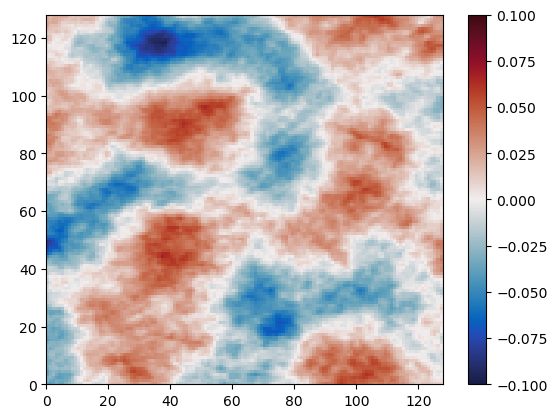

In [52]:
plt.pcolor(ssh_target,cmap=cm.cm.balance,vmin=-0.1,vmax=0.1)
plt.colorbar()

In [75]:
import xrft
eval_physics = reload(eval_physics)

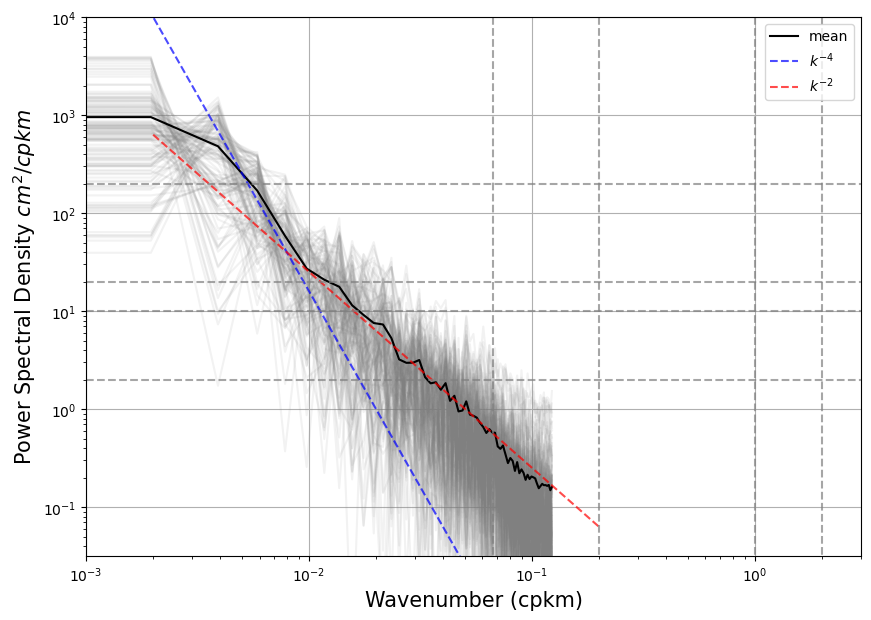

In [101]:
freqs_x, psds_x = eval_physics.compute_power_spectra_xrft(ssh_target, "SSH", 4, assert_parseval=False)

fig, axs = plt.subplots(1,1,figsize=(10,7))


for i in range(len(freqs_x)):
    axs.loglog(freqs_x[i],psds_x[i],color="grey",alpha=0.1)

axs.loglog(np.mean(freqs_x,axis=0),np.mean(psds_x,axis=0),color="k",label="mean")  
x = np.linspace(0.01, 1, 100)
axs.loglog(x*.15, (x**-4)/10**3.5, color='blue',label=r"$k^{-4}$",linestyle="dashed",alpha=0.7)
axs.loglog(x*.2, (x**-2)/10**1.2, color='red',label=r"$k^{-2}$",linestyle="dashed",alpha=0.7)

axs.hlines([2, 10,20,200],10**-3,10,color="grey",linestyle="--",alpha=0.7)
axs.vlines([1/15,1/5,1, 2],0,10**5,color="grey",linestyle="--",alpha=0.7)
axs.set_ylim(10**-1.5,10**4)
axs.set_xlim(10**-3,3)
axs.set_xlabel('Wavenumber (cpkm)',fontsize=15)
axs.set_ylabel('Power Spectral Density $cm^{2}/cpkm$',fontsize=15)
axs.legend()

axs.set_ylim(10**-1.5,10**4)
axs.set_xlim(10**-3,3)
axs.grid()

plt.show()
plt.close()

# SimVip Encoder

In [82]:
np.mean(psds_x[0],axis=0)

np.float64(28.197825636638886)